In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
DATASET_PATH = "/content/drive/MyDrive/brain-mri-images-for-brain-tumor-detection"



In [ ]:
from glob import glob

yes_path = glob(f"{DATASET_PATH}/yes/*.jpg")
no_path  = glob(f"{DATASET_PATH}/no/*.jpg")

print(f"Found {len(yes_path)} tumor images and {len(no_path)} non-tumor images.")


Found 86 tumor images and 85 non-tumor images.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
import glob
import random
import os

from os import listdir
from glob import glob
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import keras.utils as image

print("Importing is finished")


Importing is finished


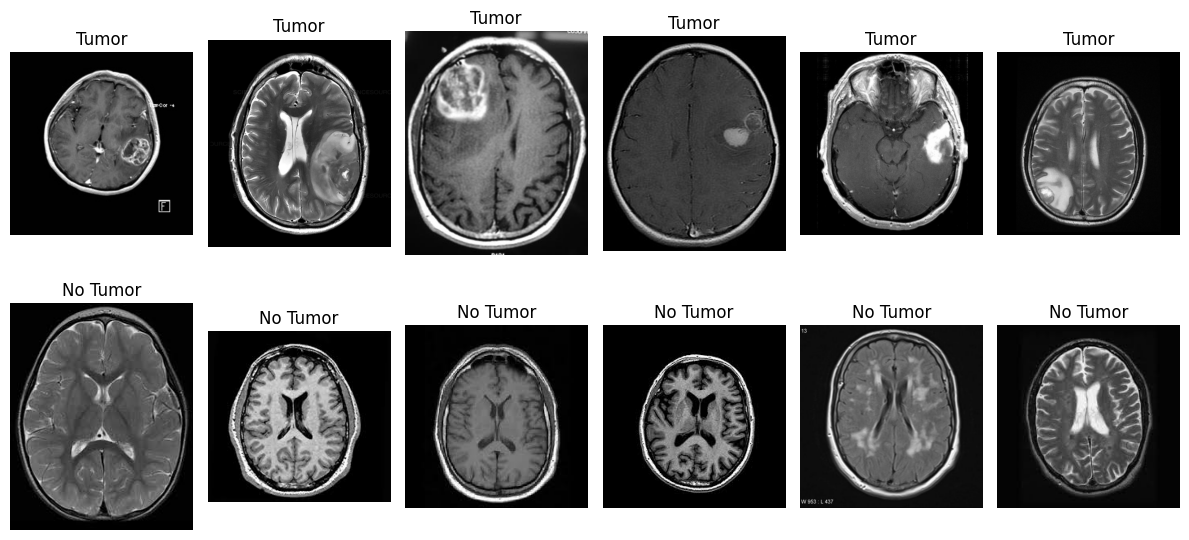

In [ ]:
import cv2
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

for i in range(6):
    # Tumor images
    img = cv2.imread(yes_path[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(2, 6, i + 1)
    plt.imshow(img)
    plt.title("Tumor")
    plt.axis("off")

    # No tumor images
    img = cv2.imread(no_path[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(2, 6, i + 7)
    plt.imshow(img)
    plt.title("No Tumor")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
desired_total = 3000

total_imgs = len(yes_path) + len(no_path)
sampling_ratio = desired_total / total_imgs

print(f"Total: {total_imgs}, Sampling ratio: {sampling_ratio:.4f}")


Total: 171, Sampling ratio: 17.5439


In [ ]:
print("Tumor images:", len(yes_path))
print("No tumor images:", len(no_path))


Tumor images: 86
No tumor images: 85


In [ ]:
img_data = []
img_labels = []

def load_images(image_paths, label):
    result = []
    for img_path in image_paths:
        if np.random.uniform() <= sampling_ratio:
            img = cv2.imread(img_path)
            img = cv2.resize(img, (100, 100))
            result.append((img, label))
    return result

In [ ]:
tumor_data = load_images(yes_path, 1)
no_tumor_data = load_images(no_path, 0)

img_data = tumor_data + no_tumor_data
np.random.shuffle(img_data)

X = np.array([i[0] for i in img_data])
y = np.array([i[1] for i in img_data])

print(f"✅ Loaded {len(X)} images")

✅ Loaded 171 images


In [ ]:
def describe_data(X, y):
    print("Total images:", len(X))
    print("Tumor images:", np.sum(y == 1))
    print("No tumor images:", np.sum(y == 0))
    print("Image shape:", X[0].shape)

describe_data(X, y)

Total images: 171
Tumor images: 86
No tumor images: 85
Image shape: (100, 100, 3)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [ ]:
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

In [ ]:
print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)

Training data shape: (119, 100, 100, 3)
Testing data shape: (52, 100, 100, 3)


In [ ]:
from tensorflow.keras.applications import ResNet50, EfficientNetB0, InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.image import resize

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 1e-4


X_train_resized = np.array([resize(img, IMG_SIZE) for img in X_train])
X_test_resized = np.array([resize(img, IMG_SIZE) for img in X_test])

print("New train shape:", X_train_resized.shape)

New train shape: (119, 224, 224, 3)


In [ ]:
def build_model(base_model, num_classes=2):
    base_model.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

def train_model(model, model_name):
    print(f"🔹 Training {model_name}...")
    history = model.fit(
        X_train_resized, y_train,
        validation_data=(X_test_resized, y_test),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=[early_stop],
        verbose=1
    )
    return history

In [ ]:
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=IMG_SIZE + (3,))
resnet_model = build_model(resnet_base)

history_resnet = train_model(resnet_model, "ResNet50")

🔹 Training ResNet50...
Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 39s 9s/step - accuracy: 0.5877 - loss: 0.8105 - val_accuracy: 0.5577 - val_loss: 0.6767
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 28s 8s/step - accuracy: 0.5672 - loss: 0.7073 - val_accuracy: 0.5000 - val_loss: 0.6849
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 29s 8s/step - accuracy: 0.5549 - loss: 0.7758 - val_accuracy: 0.4808 - val_loss: 0.6840
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 41s 8s/step - accuracy: 0.5724 - loss: 0.7281 - val_accuracy: 0.6154 - val_loss: 0.6739
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 28s 8s/step - accuracy: 0.5297 - loss: 0.8077 - val_accuracy: 0.7115 - val_loss: 0.6636
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 27s 7s/step - accuracy: 0.5295 - loss: 0.7602 - val_accuracy: 0.5385 - val_loss: 0.6571
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 43s 8s/step - accuracy: 0.5919 - loss: 0.6742 - val_accuracy: 0.5577 - val_loss: 0.6538
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 27s 8s/step - accuracy: 0.4894 - loss: 0.7732 - val_accuracy: 0.5769 - va

In [ ]:
efficientnet_base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=IMG_SIZE + (3,))
efficientnet_model = build_model(efficientnet_base)

history_efficientnet = train_model(efficientnet_model, "EfficientNetB0")

🔹 Training EfficientNetB0...
Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 26s 4s/step - accuracy: 0.5522 - loss: 0.6792 - val_accuracy: 0.4615 - val_loss: 0.6939
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - accuracy: 0.4863 - loss: 0.7031 - val_accuracy: 0.5385 - val_loss: 0.6900
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - accuracy: 0.5110 - loss: 0.6916 - val_accuracy: 0.5385 - val_loss: 0.6896
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.4653 - loss: 0.7361 - val_accuracy: 0.5385 - val_loss: 0.6900
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 4s/step - accuracy: 0.5449 - loss: 0.6998 - val_accuracy: 0.5385 - val_loss: 0.6906
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.5581 - loss: 0.6990 - val_accuracy: 0.5385 - val_loss: 0.6920


In [ ]:
inception_base = InceptionV3(weights='imagenet', include_top=False, input_shape=IMG_SIZE + (3,))
inception_model = build_model(inception_base)

history_inception = train_model(inception_model, "InceptionV3")

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
🔹 Training InceptionV3...
Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 34s 7s/step - accuracy: 0.4783 - loss: 0.9023 - val_accuracy: 0.6538 - val_loss: 0.6369
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 35s 5s/step - accuracy: 0.4914 - loss: 0.8262 - val_accuracy: 0.6923 - val_loss: 0.5845
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 24s 6s/step - accuracy: 0.7267 - loss: 0.6351 - val_accuracy: 0.7692 - val_loss: 0.5256
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 18s 5s/step - accuracy: 0.5519 - loss: 0.7345 - val_accuracy: 0.8462 - val_loss: 0.4994
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 21s 5s/step - accuracy: 0.5910 - loss: 0.6614 - val_accuracy: 0.8654 - val_loss: 0.4730
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 20s 5s/step - accuracy: 0.7364 - loss: 0.5751 - val_accuracy: 0.8654 - val_loss: 0.4423
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 20s 5s/step - accuracy: 0.7693 - loss: 0.4589 - val_accuracy: 0.8654 - val_loss: 0.4186
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 23s 6s/step - accur

In [ ]:
def evaluate_model(model, name):
    loss, acc = model.evaluate(X_test_resized, y_test, verbose=0)
    print(f"{name} - Accuracy: {acc:.4f}, Loss: {loss:.4f}")

In [ ]:
evaluate_model(resnet_model, "ResNet50")
evaluate_model(efficientnet_model, "EfficientNetB0")
evaluate_model(inception_model, "InceptionV3")

ResNet50 - Accuracy: 0.5769, Loss: 0.6223
EfficientNetB0 - Accuracy: 0.5385, Loss: 0.6896
InceptionV3 - Accuracy: 0.8654, Loss: 0.3267


In [ ]:
def classification_metrics(model, name):
    y_pred = model.predict(X_test_resized)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)
    print(f"\n{name} Classification Report:")
    print(classification_report(y_true_classes, y_pred_classes))

In [ ]:
classification_metrics(resnet_model, "ResNet50")

2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 7s/step

ResNet50 Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.33      0.42        24
           1       0.58      0.79      0.67        28

    accuracy                           0.58        52
   macro avg       0.58      0.56      0.54        52
weighted avg       0.58      0.58      0.55        52



In [ ]:
classification_metrics(efficientnet_model, "EfficientNetB0")

2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step

EfficientNetB0 Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        24
           1       0.54      1.00      0.70        28

    accuracy                           0.54        52
   macro avg       0.27      0.50      0.35        52
weighted avg       0.29      0.54      0.38        52



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
classification_metrics(inception_model, "InceptionV3")

2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step

InceptionV3 Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.79      0.84        24
           1       0.84      0.93      0.88        28

    accuracy                           0.87        52
   macro avg       0.87      0.86      0.86        52
weighted avg       0.87      0.87      0.86        52



In [ ]:
def plot_accuracy(history, model_name):
    plt.figure(figsize=(6, 4))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

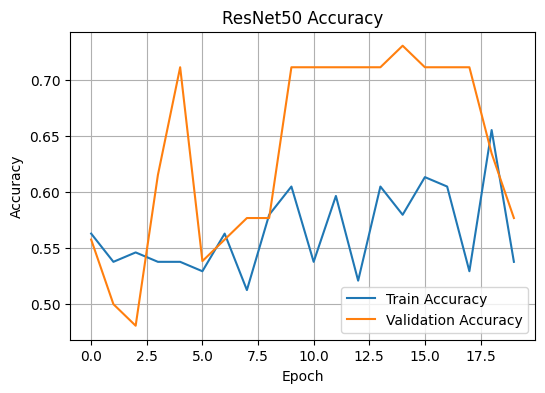

In [ ]:
plot_accuracy(history_resnet, "ResNet50")

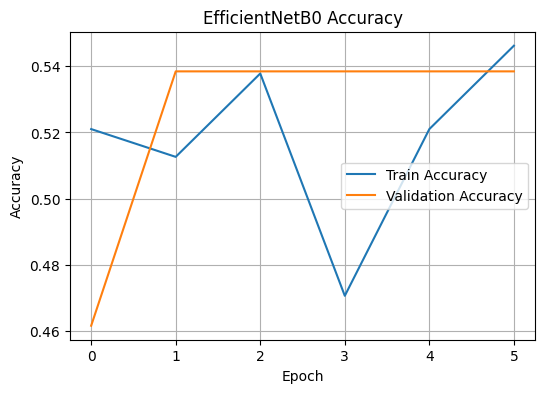

In [ ]:
plot_accuracy(history_efficientnet, "EfficientNetB0")

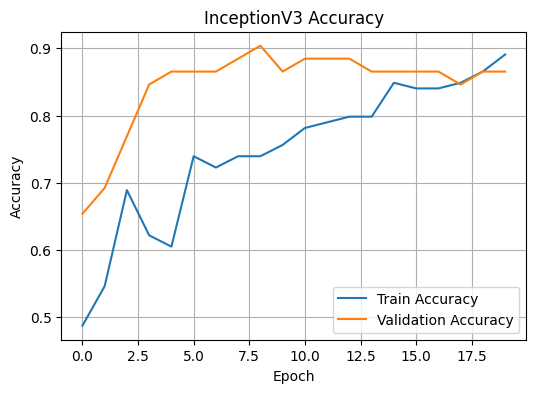

In [ ]:
plot_accuracy(history_inception, "InceptionV3")

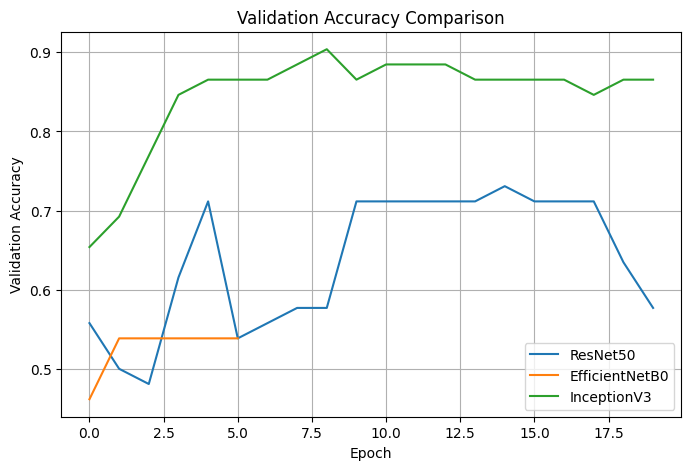

In [ ]:
plt.figure(figsize=(8, 5))

plt.plot(history_resnet.history['val_accuracy'], label='ResNet50')
plt.plot(history_efficientnet.history['val_accuracy'], label='EfficientNetB0')
plt.plot(history_inception.history['val_accuracy'], label='InceptionV3')

plt.title('Validation Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

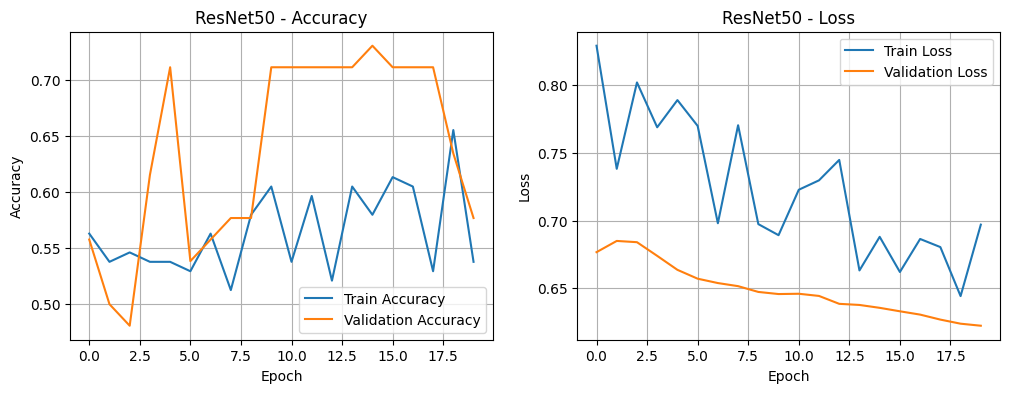

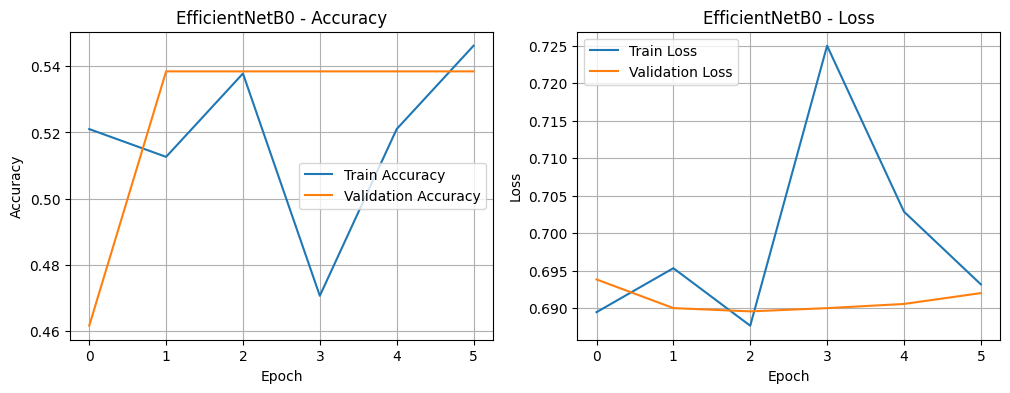

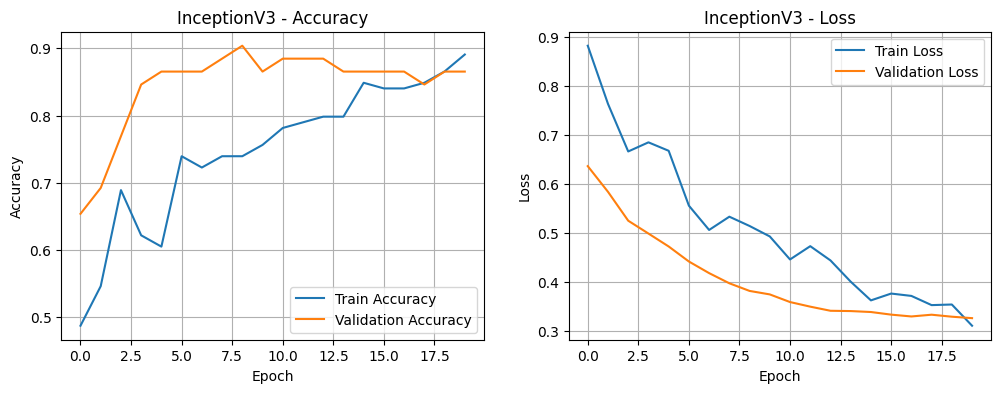

In [ ]:
def plot_training_history(history, model_name):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    axs[0].plot(history.history['accuracy'], label='Train Accuracy')
    axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axs[0].set_title(f'{model_name} - Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Accuracy')
    axs[0].legend()
    axs[0].grid(True)

    axs[1].plot(history.history['loss'], label='Train Loss')
    axs[1].plot(history.history['val_loss'], label='Validation Loss')
    axs[1].set_title(f'{model_name} - Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Loss')
    axs[1].legend()
    axs[1].grid(True)

    plt.show()

plot_training_history(history_resnet, "ResNet50")
plot_training_history(history_efficientnet, "EfficientNetB0")
plot_training_history(history_inception, "InceptionV3")

2/2 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step


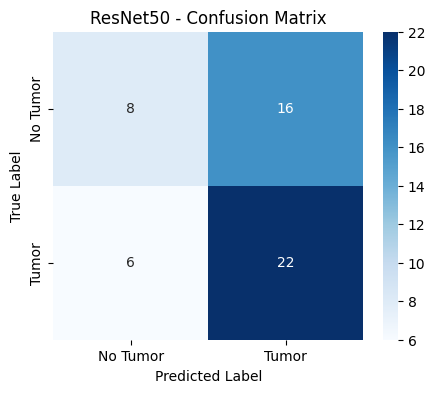

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step


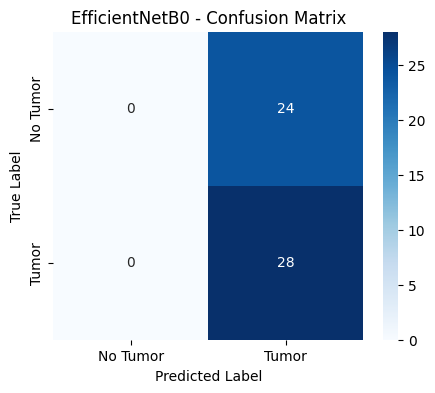

2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step


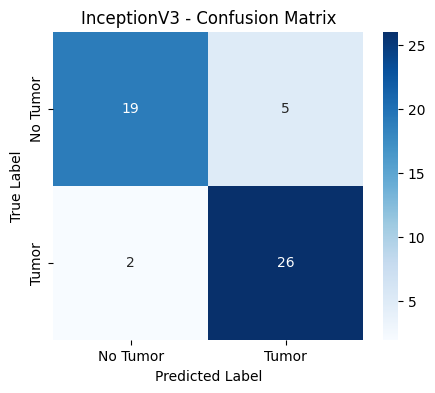

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    cm = confusion_matrix(y_true_classes, y_pred_classes)

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=['No Tumor', 'Tumor'],
                yticklabels=['No Tumor', 'Tumor'])
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title(f'{model_name} - Confusion Matrix')
    plt.show()

plot_confusion_matrix(resnet_model, X_test_resized, y_test, "ResNet50")
plot_confusion_matrix(efficientnet_model, X_test_resized, y_test, "EfficientNetB0")
plot_confusion_matrix(inception_model, X_test_resized, y_test, "InceptionV3")

In [ ]:
from tensorflow.keras.applications import DenseNet121

densenet_base = DenseNet121(weights='imagenet', include_top=False, input_shape=IMG_SIZE + (3,))
densenet_model = build_model(densenet_base)

history_densenet = densenet_model.fit(
    X_train_resized, y_train,
    validation_data=(X_test_resized, y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 51s 11s/step - accuracy: 0.5295 - loss: 0.8948 - val_accuracy: 0.5962 - val_loss: 0.7339
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 25s 7s/step - accuracy: 0.5723 - loss: 0.8778 - val_accuracy: 0.5962 - val_loss: 0.6959
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 44s 8s/step - accuracy: 0.5710 - loss: 0.7977 - val_accuracy: 0.6731 - val_loss: 0.6542
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 42s 8s/step - accuracy: 0.5199 - loss: 0.9307 - val_accuracy: 0.7308 - val_loss: 0.6160
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 38s 7s/step - accuracy: 0.5884 - loss: 0.8123 - val_accuracy: 0.6923 - val_loss: 0.5975
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 43s 8s/step - accuracy: 0.5762 - loss: 0.7486 - val_accuracy: 0.7115 - val_loss: 0.5761
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 39s 7s/step - accuracy: 0.5995 - loss: 0.7710 - val_accuracy: 0.7692 - val_loss: 0.5483
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 43s 8s/step - accuracy: 0.5811 - loss: 0.780

In [ ]:
from tensorflow.keras.applications import Xception

xception_base = Xception(weights='imagenet', include_top=False, input_shape=IMG_SIZE + (3,))
xception_model = build_model(xception_base)

history_xception = xception_model.fit(
    X_train_resized, y_train,
    validation_data=(X_test_resized, y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 52s 13s/step - accuracy: 0.5010 - loss: 0.7326 - val_accuracy: 0.4423 - val_loss: 0.6864
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 35s 9s/step - accuracy: 0.5053 - loss: 0.6946 - val_accuracy: 0.5577 - val_loss: 0.6769
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 41s 10s/step - accuracy: 0.6352 - loss: 0.6184 - val_accuracy: 0.5769 - val_loss: 0.6598
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 40s 9s/step - accuracy: 0.5707 - loss: 0.6305 - val_accuracy: 0.6538 - val_loss: 0.6252
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 42s 10s/step - accuracy: 0.7846 - loss: 0.5493 - val_accuracy: 0.6538 - val_loss: 0.5962
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 45s 13s/step - accuracy: 0.7289 - loss: 0.5732 - val_accuracy: 0.7692 - val_loss: 0.5642
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 44s 13s/step - accuracy: 0.7621 - loss: 0.5189 - val_accuracy: 0.7692 - val_loss: 0.5403
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 43s 13s/step - accuracy: 0.8320 - loss: 

In [ ]:
evaluate_model(densenet_model, "DenseNet121")
evaluate_model(xception_model, "Xception")

DenseNet121 - Accuracy: 0.8269, Loss: 0.4284
Xception - Accuracy: 0.8269, Loss: 0.4268


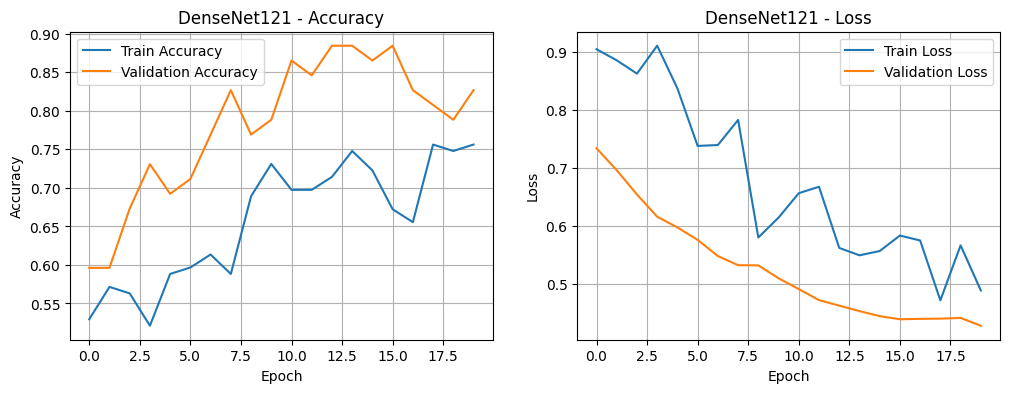

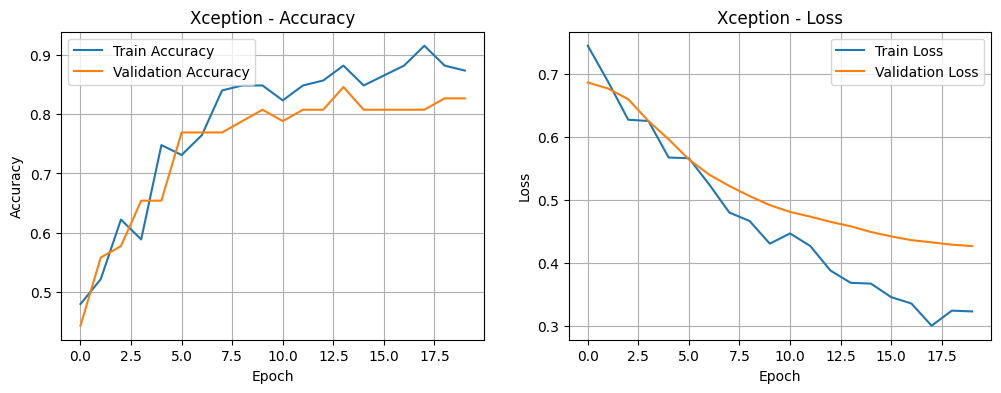

In [ ]:
plot_training_history(history_densenet, "DenseNet121")
plot_training_history(history_xception, "Xception")

2/2 ━━━━━━━━━━━━━━━━━━━━ 16s 6s/step


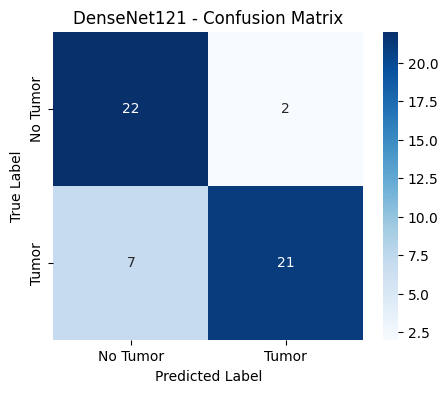

2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 4s/step


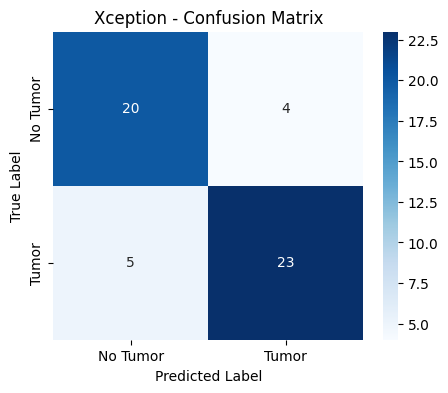

In [ ]:
def plot_confusion_matrix(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    cm = confusion_matrix(y_true_classes, y_pred_classes)

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=['No Tumor', 'Tumor'],
                yticklabels=['No Tumor', 'Tumor'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'{model_name} - Confusion Matrix')
    plt.show()

plot_confusion_matrix(densenet_model, X_test_resized, y_test, "DenseNet121")

plot_confusion_matrix(xception_model, X_test_resized, y_test, "Xception")

/tmp/ipython-input-3587368801.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=labels_str, palette='viridis')


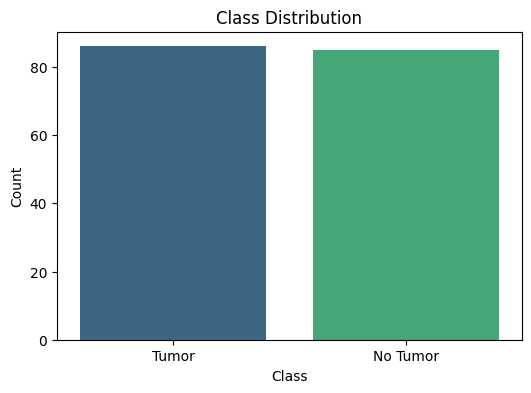

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

labels_str = ['No Tumor' if label == 0 else 'Tumor' for label in y]

plt.figure(figsize=(6, 4))
sns.countplot(x=labels_str, palette='viridis')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

/tmp/ipython-input-16727284.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(avg_brightness_tumor, label='Tumor', shade=True)
/tmp/ipython-input-16727284.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(avg_brightness_no, label='No Tumor', shade=True)


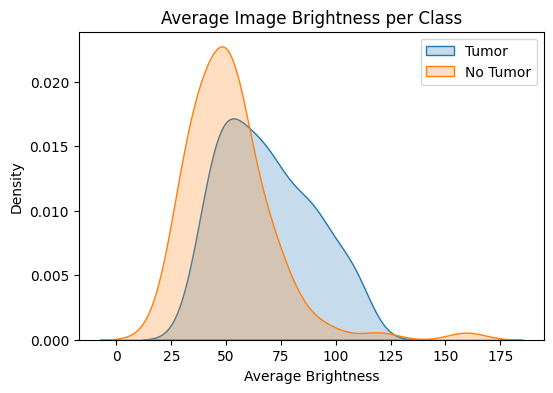

In [ ]:
import numpy as np

avg_brightness_tumor = [np.mean(img) for img, label in zip(X, y) if label == 1]
avg_brightness_no = [np.mean(img) for img, label in zip(X, y) if label == 0]

plt.figure(figsize=(6, 4))
sns.kdeplot(avg_brightness_tumor, label='Tumor', shade=True)
sns.kdeplot(avg_brightness_no, label='No Tumor', shade=True)
plt.title('Average Image Brightness per Class')
plt.xlabel('Average Brightness')
plt.ylabel('Density')
plt.legend()
plt.show()

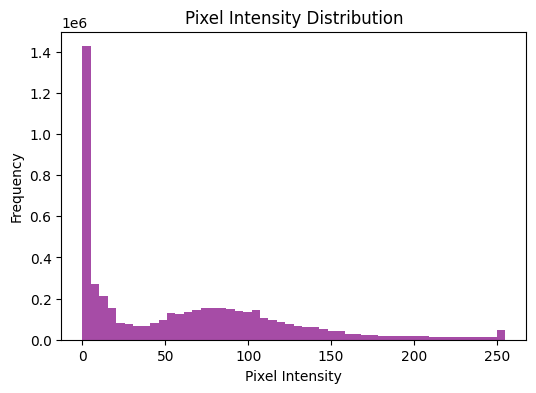

In [ ]:
plt.figure(figsize=(6, 4))
plt.hist(X.ravel(), bins=50, color='purple', alpha=0.7)
plt.title('Pixel Intensity Distribution')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.show()

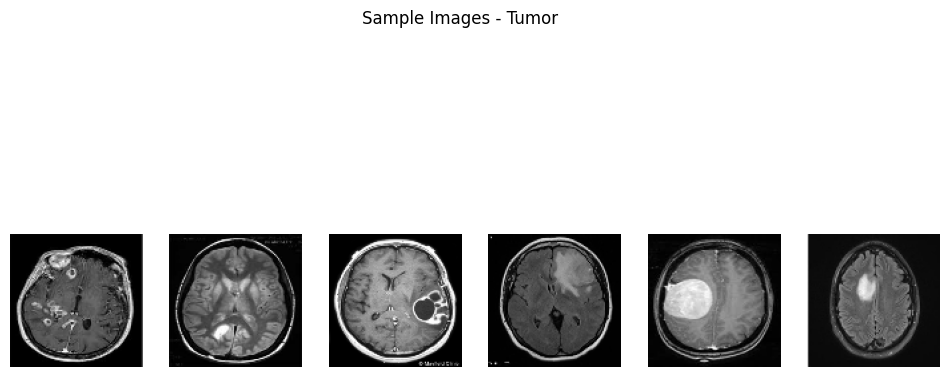

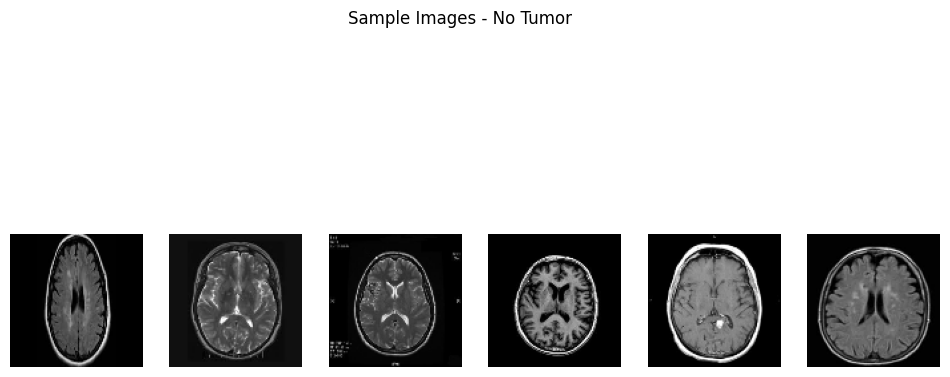

In [ ]:
import random

def show_random_images(X, y, class_label, samples=6):
    indices = [i for i, label in enumerate(y) if label == class_label]
    selected = random.sample(indices, samples)

    plt.figure(figsize=(12, 6))
    for idx, img_idx in enumerate(selected):
        plt.subplot(1, samples, idx+1)
        plt.imshow(X[img_idx].astype('uint8'))
        plt.axis('off')
    title = 'Tumor' if class_label == 1 else 'No Tumor'
    plt.suptitle(f'Sample Images - {title}')
    plt.show()

show_random_images(X, y, 1)
show_random_images(X, y, 0)

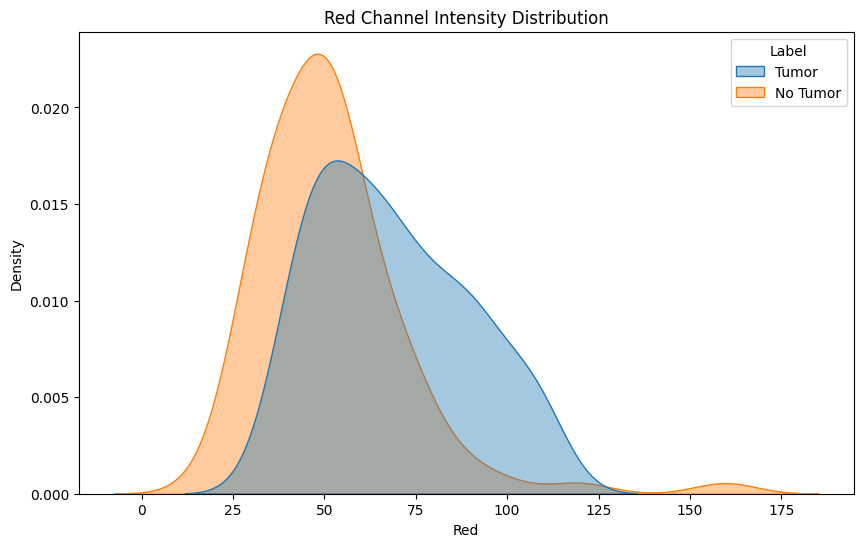

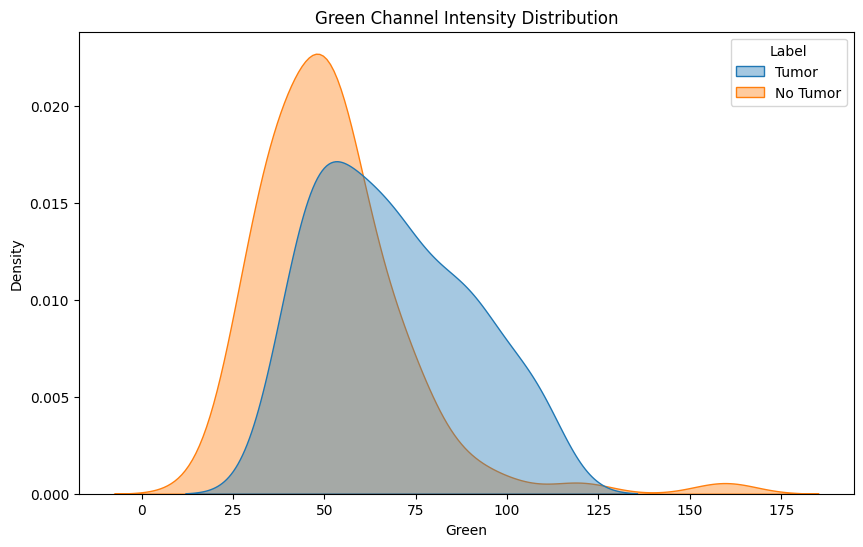

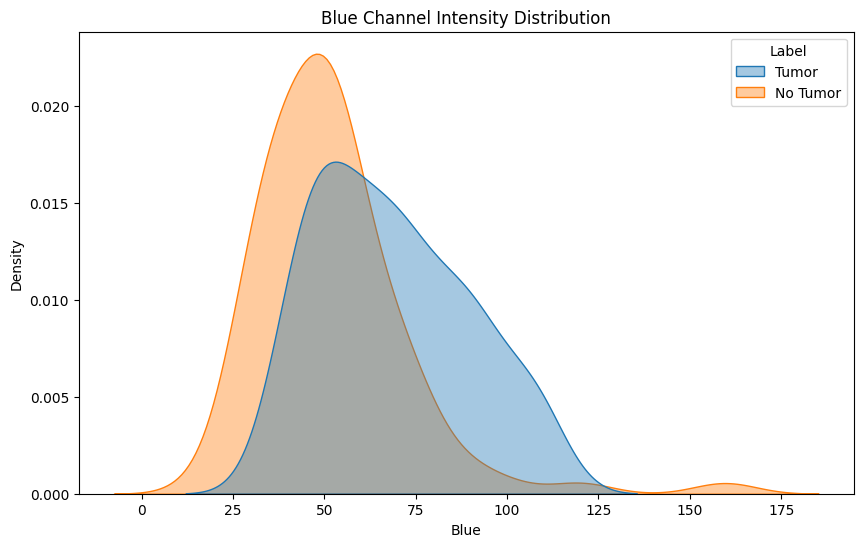

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

avg_red = [np.mean(img[:, :, 0]) for img in X]
avg_green = [np.mean(img[:, :, 1]) for img in X]
avg_blue = [np.mean(img[:, :, 2]) for img in X]

import pandas as pd
df_colors = pd.DataFrame({
    'Red': avg_red,
    'Green': avg_green,
    'Blue': avg_blue,
    'Label': ['Tumor' if label == 1 else 'No Tumor' for label in y]
})

plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_colors, x='Red', hue='Label', fill=True, alpha=0.4, common_norm=False)
plt.title('Red Channel Intensity Distribution')
plt.show()

plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_colors, x='Green', hue='Label', fill=True, alpha=0.4, common_norm=False)
plt.title('Green Channel Intensity Distribution')
plt.show()

plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_colors, x='Blue', hue='Label', fill=True, alpha=0.4, common_norm=False)
plt.title('Blue Channel Intensity Distribution')
plt.show()

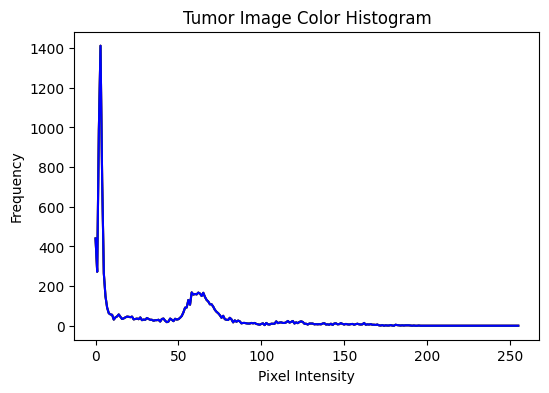

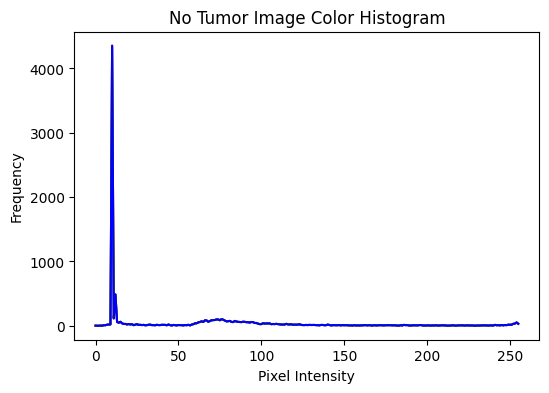

In [ ]:
def plot_color_histogram(image, title):
    color = ('r', 'g', 'b')
    plt.figure(figsize=(6, 4))
    for i, col in enumerate(color):
        hist = cv2.calcHist([image], [i], None, [256], [0, 256])
        plt.plot(hist, color=col)
    plt.title(title)
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.show()

plot_color_histogram(X[np.where(y==1)[0][0]].astype('uint8'), 'Tumor Image Color Histogram')

plot_color_histogram(X[np.where(y==0)[0][0]].astype('uint8'), 'No Tumor Image Color Histogram')

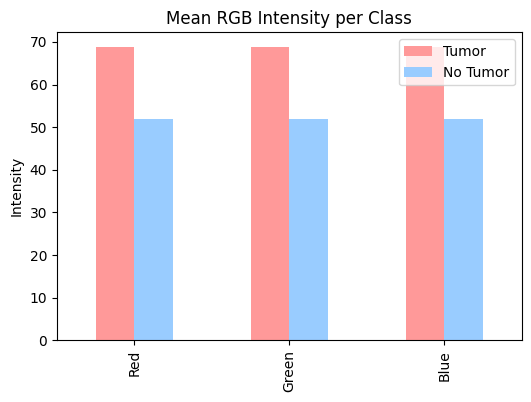

In [ ]:
mean_rgb_tumor = df_colors[df_colors['Label'] == 'Tumor'][['Red', 'Green', 'Blue']].mean()
mean_rgb_no = df_colors[df_colors['Label'] == 'No Tumor'][['Red', 'Green', 'Blue']].mean()

mean_df = pd.DataFrame({'Tumor': mean_rgb_tumor, 'No Tumor': mean_rgb_no})
mean_df.plot(kind='bar', figsize=(6, 4), color=['#FF9999', '#99CCFF'])
plt.title('Mean RGB Intensity per Class')
plt.ylabel('Intensity')
plt.show()

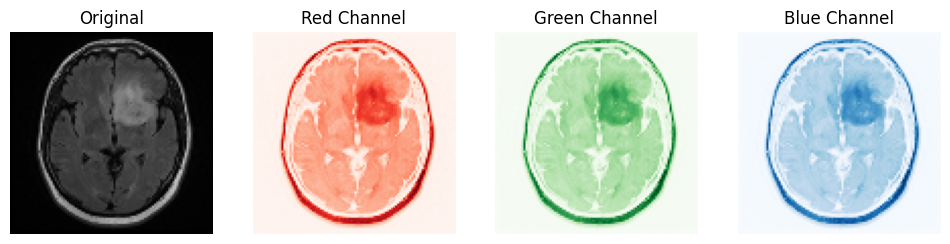

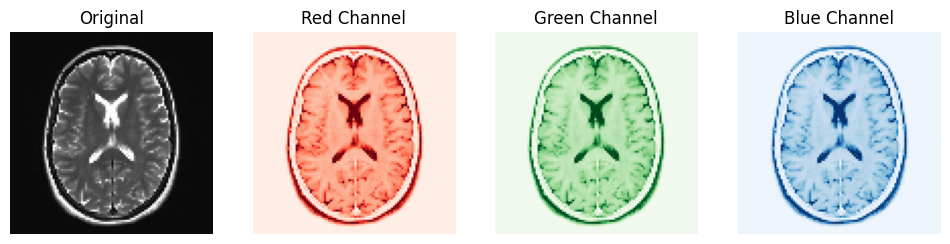

In [ ]:
def show_color_channels(image):
    R, G, B = image[:,:,0], image[:,:,1], image[:,:,2]
    fig, axs = plt.subplots(1, 4, figsize=(12, 4))
    axs[0].imshow(image.astype('uint8'))
    axs[0].set_title('Original')
    axs[1].imshow(R, cmap='Reds')
    axs[1].set_title('Red Channel')
    axs[2].imshow(G, cmap='Greens')
    axs[2].set_title('Green Channel')
    axs[3].imshow(B, cmap='Blues')
    axs[3].set_title('Blue Channel')
    for ax in axs: ax.axis('off')
    plt.show()

show_color_channels(X[np.where(y==1)[0][0]].astype('uint8'))

show_color_channels(X[np.where(y==0)[0][0]].astype('uint8'))

In [1]:
classification_metrics(densenet_model, "DenseNet121")

NameError: name 'classification_metrics' is not defined

In [ ]:
classification_metrics(xception_model, "Xception")